In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import jarque_bera
import re
import attila_utils

In [2]:
treatments_CO28152 = {
    'A': 'Amiloride TG',
    'B': 'HCQ TG',
    'C': 'HCQ nano TG',
    'D': 'Saline TG',
    'E': 'R-HCQ TG',
    'F': 'S-HCQ TG',
    'G': 'TUDCA TG',
    'H': 'Saline WT',
    'I': 'TUDCA WT',
    'J': 'DMSO WT',
}

treatment_levels_CO28152 = [
    'Saline TG',
    'TUDCA TG',
    'HCQ TG',
    'HCQ nano TG',
    'R-HCQ TG',
    'S-HCQ TG',
    'Amiloride TG',
    'Saline WT',
    'TUDCA WT',
    'DMSO WT',
]

treatment_levels_CO28152_TUDCA_HCQ = ['Saline TG', 'TUDCA TG', 'HCQ TG', 'Saline WT']

treatments_CO28154 = {
    'A': 'Saline TG',
    #'B': 'Amiloride + HCQ TG', # absent from data
    'C': 'TUDCA + HCQ TG',
    'D': 'Arundine low dose TG',
    'E': 'Arundine mid dose TG',
    'F': 'Arundine high dose TG',
    'G': 'Vehicle (Arundine) TG',
    'H': 'Arundine high dose WT',
    #'I': 'Amiloride + HCQ WT', # absent from data
    'J': 'TUDCA + HCQ WT',
    'K': 'Saline WT',
    'L': 'Vehicle (Arundine) WT',
}

treatment_levels_CO28154 = [
    'Saline TG',
    'TUDCA + HCQ TG',
    'HCQ nano TG',
    'Saline WT',
    'TUDCA WT',
    'TUDCA + HCQ WT',
    'Vehicle (Arundine) TG',
    'Arundine low dose TG',
    'Arundine mid dose TG',
    'Arundine high dose TG',
    'Vehicle (Arundine) WT',
    'Arundine high dose WT',
]

treatment_levels_CO28154_TUDCA_HCQ = ['Saline TG', 'TUDCA + HCQ TG', 'Saline WT']

In [3]:
fpath = '../../resources/QPS/5xFAD-mouse/inflammation-cleaned.csv'
df = pd.read_csv(fpath, header=[0,1], index_col=[0, 1, 2, 3, 4, 5]).stack(level=0)
covariates = df.index.to_frame().rename({0: 'Study', 1: 'Cohort', 2: 'Group', 3: 'IRN', 4: 'Sex', 5: 'Genotype', 6: 'Region'}, axis=1)
data = pd.concat([covariates, df], axis=1)
data_CO28154, data_CO28152 = [data.xs(s, level=0, axis=0) for s in ['CO28154', 'CO28152']]
#Z = zip([data_CO28154, data_CO28152], [treatments_CO28154, treatments_CO28152])
#data_CO28154, data_CO28152 = [pd.concat([df.Group.apply(lambda x: treat[x]).to_frame('Treatment'), df], axis=1) for df, treat in Z]
Z = zip([data_CO28154, data_CO28152], [treatments_CO28154, treatments_CO28152], [treatment_levels_CO28154, treatment_levels_CO28152])
data_CO28154, data_CO28152 = [pd.concat([pd.DataFrame({'Treatment': pd.Categorical(df.Group.apply(lambda x: treat[x]), ordered=True, categories=tl)}, index=df.index), df], axis=1) for df, treat, tl in Z]
data_CO28152

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_97762/3357096405.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = pd.read_csv(fpath, header=[0,1], index_col=[0, 1, 2, 3, 4, 5]).stack(level=0)


Treatment    Study Cohort Group      IRN  \
I  A 15117   f tg/wt Cortex       Amiloride TG  CO28152      I     A    15117   
                     Hippocampus  Amiloride TG  CO28152      I     A    15117   
     15119   f tg/wt Cortex       Amiloride TG  CO28152      I     A    15119   
                     Hippocampus  Amiloride TG  CO28152      I     A    15119   
     14627 A f tg/wt Cortex       Amiloride TG  CO28152      I     A  14627 A   
...                                        ...      ...    ...   ...      ...   
V  J 16180   m wt/wt Hippocampus       DMSO WT  CO28152      V     J    16180   
     16192   m wt/wt Cortex            DMSO WT  CO28152      V     J    16192   
                     Hippocampus       DMSO WT  CO28152      V     J    16192   
VI J 16220   m wt/wt Cortex            DMSO WT  CO28152     VI     J    16220   
                     Hippocampus       DMSO WT  CO28152     VI     J    16220   

                                 Sex Genotype       Region     IFN-γ  \
I  A 15117   f tg/wt Cortex        f    tg/wt       Cortex  0.909502   
                     Hippocampus   f    tg/wt  Hippocampus  1.363656   
     15119   f tg/wt Cortex        f    tg/wt       Cortex  0.891955   
                     Hippocampus   f    tg/wt  Hippocampus  1.783909   
     14627 A f tg/wt Cortex        f    tg/wt       Cortex       NaN   
...                               ..      ...          ...       ...   
V  J 16180   m wt/wt Hippocampus   m    wt/wt  Hippocampus  1.329405   
     16192   m wt/wt Cortex        m    wt/wt       Cortex       NaN   
                     Hippocampus   m    wt/wt  Hippocampus  1.573556   
VI J 16220   m wt/wt Cortex        m    wt/wt       Cortex  1.133145   
                     Hippocampus   m    wt/wt  Hippocampus  1.858643   

                                       IL-10    IL-12p70       IL-1β  \
I  A 15117   f tg/wt Cortex        52.947600  202.771770   61.120545   
                     Hippocampus   95.928746  544.594858   58.234632   
     15119   f tg/wt Cortex        62.994128  235.264681  224.522422   
                     Hippocampus  105.895200  416.483156  102.529155   
     14627 A f tg/wt Cortex        47.147395  176.920488  107.202083   
...                                      ...         ...         ...   
V  J 16180   m wt/wt Hippocampus   84.514768  342.734613    3.384879   
     16192   m wt/wt Cortex        52.212405  202.771770    5.184115   
                     Hippocampus   91.380878  394.302892    3.036077   
VI J 16220   m wt/wt Cortex        43.927905  277.620131    7.874649   
                     Hippocampus   96.572871  469.691497    5.568782   

                                       IL-2      IL-4       IL-5        IL-6  \
I  A 15117   f tg/wt Cortex       14.168717  7.143437   8.380053  125.645282   
                     Hippocampus  30.038535       NaN  20.231515  246.794884   
     15119   f tg/wt Cortex       10.371135  9.234846   7.639892  118.149094   
                     Hippocampus  23.915704       NaN  16.548931  266.264092   
     14627 A f tg/wt Cortex       12.241247  9.713188   8.538345  118.149094   
...                                     ...       ...        ...         ...   
V  J 16180   m wt/wt Hippocampus  23.048889       NaN  16.235774  163.233566   
     16192   m wt/wt Cortex       10.654439  8.863240  10.430129   95.597270   
                     Hippocampus  26.241874       NaN  16.741918  190.636434   
VI J 16220   m wt/wt Cortex       10.142874  7.017455  11.079794  121.795933   
                     Hippocampus  25.661806       NaN  16.362349  179.510532   

                                      KC/GRO      TNF-α  
I  A 15117   f tg/wt Cortex       132.565891  24.005835  
                     Hippocampus  365.773958  28.788045  
     15119   f tg/wt Cortex       201.620071  25.828643  
                     Hippocampus  303.907752  24.082363  
     14627 A f tg/wt Cortex       206.294724  21.884322  
...                      

In [4]:
def take_sel_treatments(df, sel_treatments):
    df = df.loc[df.Treatment.isin(sel_treatments)]
    df = df.melt(id_vars=df.loc[:, :'Region'].columns, var_name='Cytokine', value_name='Level')
    df['Treatment'] = pd.Categorical(df.Treatment, ordered=True, categories=sel_treatments)
    return(df)

def plot_data(df):
    g = sns.FacetGrid(df, row='Cytokine', col='Region', hue='Sex', palette=['red', 'blue'], sharex=False, margin_titles=True)
    #g.map(sns.boxplot, 'Level', 'Treatment', fill=False)
    g.map(sns.swarmplot, 'Level', 'Treatment', alpha=.7)
    return(g)

/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


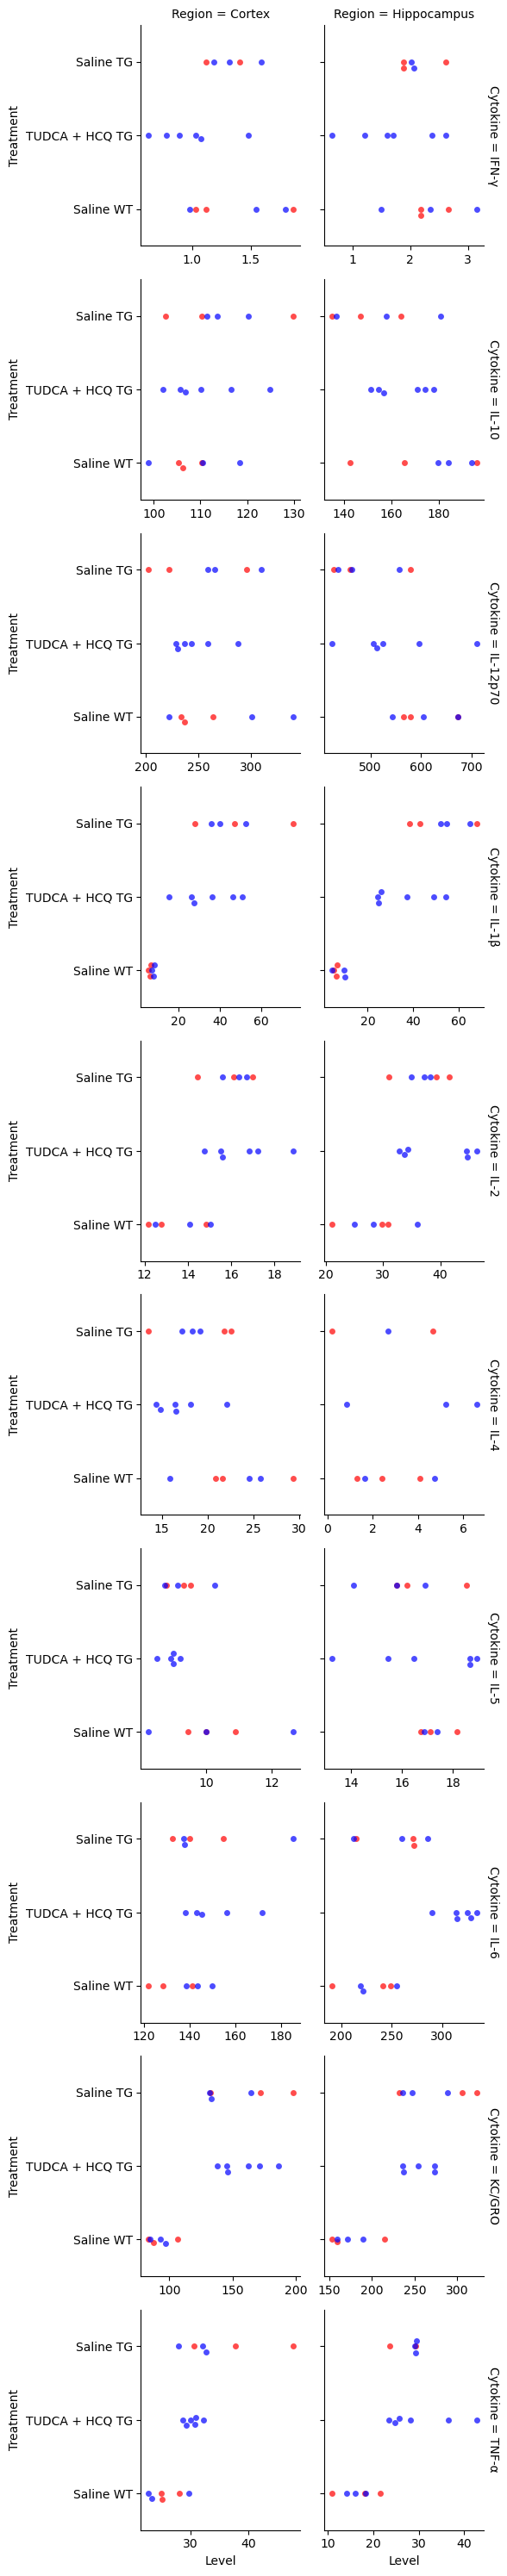

In [5]:
df = take_sel_treatments(data_CO28154, treatment_levels_CO28154_TUDCA_HCQ)
g = plot_data(df)

/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


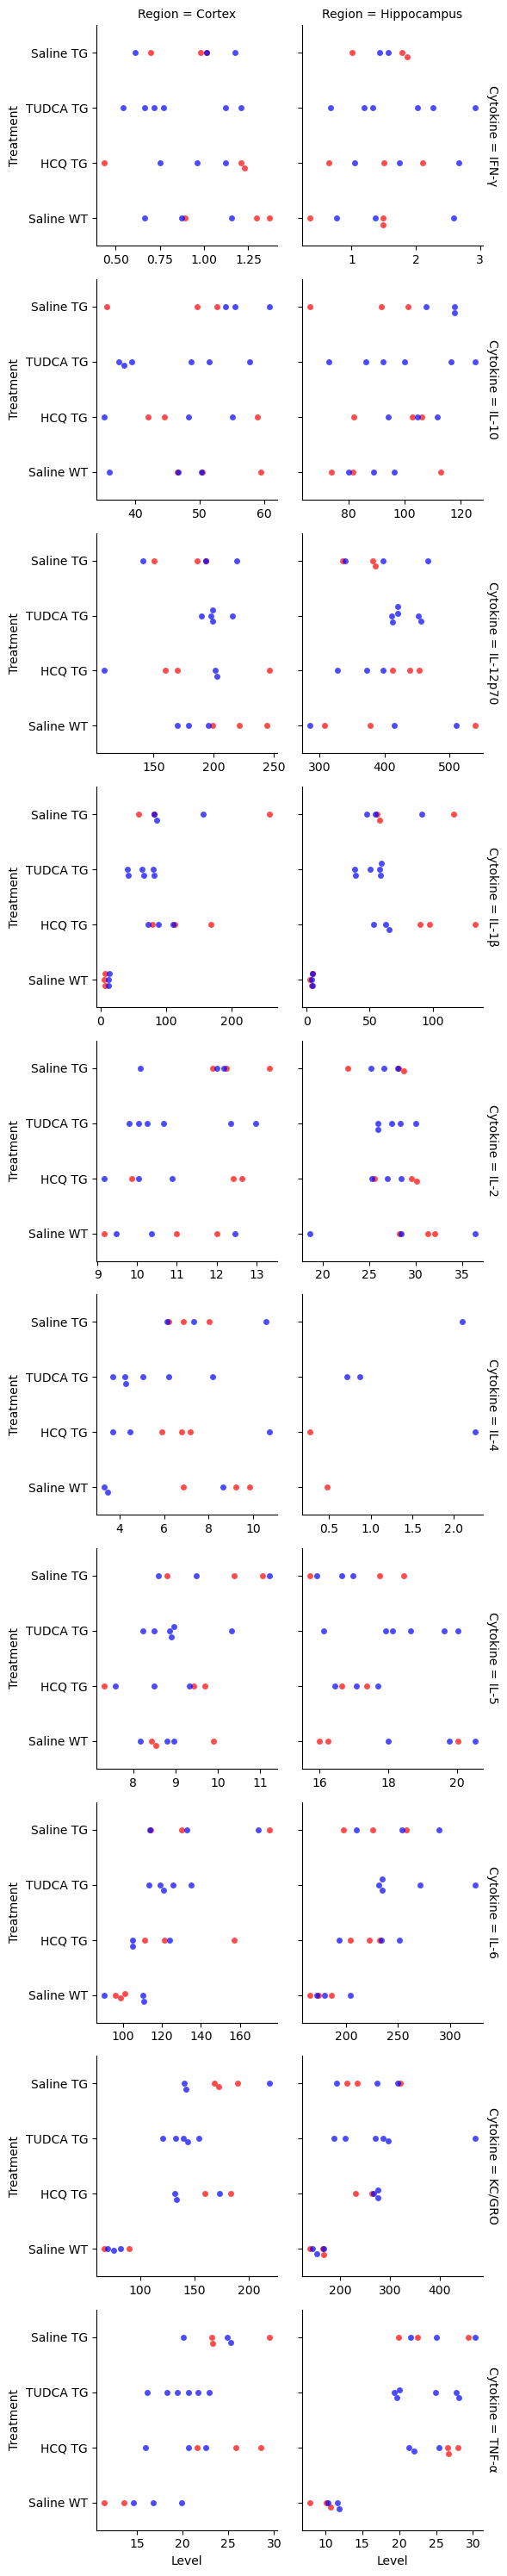

In [6]:
df = take_sel_treatments(data_CO28152, treatment_levels_CO28152_TUDCA_HCQ)
g = plot_data(df)

In [7]:
default_formula = 'Level ~ Treatment + Region'
default_formula_2 = 'Level ~ (Treatment + Region) ** 2'

def fit_one(formula=default_formula, cytokine='IL-1β', treatments=treatment_levels_CO28154_TUDCA_HCQ, data=data_CO28154):
    data = take_sel_treatments(data, treatments)
    data = data.loc[data.Cytokine == cytokine]
    data['Region'] = pd.Categorical(data.Region, ordered=True, categories=['Cortex', 'Hippocampus'])
    result = smf.ols(formula, data=data.dropna()).fit()
    return(result)

res = fit_one(default_formula, 'IL-1β', treatment_levels_CO28154_TUDCA_HCQ, data_CO28154)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Level   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     31.36
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           1.19e-09
Time:                        16:29:41   Log-Likelihood:                -135.60
No. Observations:                  36   AIC:                             279.2
Df Residuals:                      32   BIC:                             285.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      48.4397      3.699     13.096      0.000      40.905      55.974
Treatment[T.TUDCA + HCQ TG]   -15.1890      4.530     -3.353      0.002     -24.417      -5.961
Treatment[T.Saline WT]        -43.1472      4.530     -9.524      0.000     -52.375     -33.920
Region[T.Hippocampus]           3.1432      3.699      0.850      0.402      -4.391      10.678
==============================================================================
Omnibus:                        1.578   Durbin-Watson:                   1.131
Prob(Omnibus):                  0.454   Jarque-Bera (JB):                1.049
Skew:                           0.418   Prob(JB):                        0.592
Kurtosis:                       3.021   Cond. No.                         4.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
def fit_all(formula='Level ~ Treatment + Region', treatments=['Saline TG', 'TUDCA + HCQ TG', 'Saline WT'], data=data_CO28154):
    #formulas = ['Level ~ Treatment + Region', 'Level ~ (Treatment + Region) ** 2']
    cytokines = data_CO28154.loc[:, 'Region':].columns[1:]
    datas = [data, data.xs('m', level=3, axis=0)]
    #l = [fit_one(default_formula, cytokine=c, treatments=treatments, data=data) for c in cytokines]
    #res = pd.Series(l, index=cytokines)
    a = np.array([[fit_one(formula, cytokine=c, treatments=treatments, data=d) for c in cytokines] for d in datas])
    res = pd.DataFrame(a.transpose(), columns=['both sexes', 'males only'], index=cytokines)
    return(res)

def fit_all_all(data, l_treatment_levels):
    l_formulas = [default_formula, default_formula, default_formula, default_formula_2]
    #l_treatment_levels = [['Saline TG', 'Saline WT'], ['Saline TG', 'TUDCA + HCQ TG'], treatment_levels_CO28154_TUDCA_HCQ, treatment_levels_CO28154_TUDCA_HCQ]
    l_names = ['genotype treatment', 'drug treatment', 'all treatments', 'all treatments * region']
    Z = zip(l_formulas, l_treatment_levels)
    l = [fit_all(f, t, data) for f, t in Z]
    df = pd.concat(l, axis=1)
    results = pd.DataFrame(df.to_numpy(), columns=pd.MultiIndex.from_product([l_names, ['both sexes', 'males only']]), index=df.index)
    return(results)

l_treatment_levels_CO28154 = [['Saline TG', 'Saline WT'], ['Saline TG', 'TUDCA + HCQ TG'], treatment_levels_CO28154_TUDCA_HCQ, treatment_levels_CO28154_TUDCA_HCQ]
results_CO28154 = fit_all_all(data_CO28154, l_treatment_levels_CO28154)

l_treatment_levels_CO28152 = [['Saline TG', 'Saline WT'], ['Saline TG', 'TUDCA TG', 'HCQ TG'], treatment_levels_CO28152_TUDCA_HCQ, treatment_levels_CO28152_TUDCA_HCQ]
results_CO28152 = fit_all_all(data_CO28152, l_treatment_levels_CO28152)

In [9]:
results_CO28154.map(lambda r: jarque_bera(r.resid)[1])

genotype treatment            drug treatment             \
                 both sexes males only     both sexes males only   
IFN-γ              0.925362   0.954093       0.580842   0.758637   
IL-10              0.723443   0.475389       0.785400   0.906664   
IL-12p70           0.468219   0.816707       0.053786   0.044412   
IL-1β              0.142546   0.915728       0.507810   0.541816   
IL-2               0.506072   0.926868       0.956957   0.840978   
IL-4               0.996131   0.828898       0.644158   0.717574   
IL-5               0.544237   0.962702       0.685191   0.837473   
IL-6               0.698967   0.808046       0.693435   0.716690   
KC/GRO             0.521853   0.649054       0.492637   0.488089   
TNF-α              0.137352   0.859943       0.000642   0.006026   

         all treatments            all treatments * region             
             both sexes males only              both sexes males only  
IFN-γ          0.877845   0.977011                0.897121   0.972344  
IL-10          0.812219   0.556037                0.713006   0.947400  
IL-12p70       0.401547   0.223953                0.126247   0.124667  
IL-1β          0.591764   0.684555                0.380592   0.745955  
IL-2           0.979699   0.752988                0.969082   0.922024  
IL-4           0.657575   0.620207                0.932439   0.866250  
IL-5           0.690714   0.991989                0.217124   0.519745  
IL-6           0.453699   0.662905                0.745276   0.980436  
KC/GRO         0.463418   0.525770                0.491526   0.402599  
TNF-α          0.000054   0.000188                0.005131   0.001550

In [10]:
results_CO28152.map(lambda r: jarque_bera(r.resid)[1])

genotype treatment            drug treatment                \
                 both sexes males only     both sexes    males only   
IFN-γ          2.243971e-01   0.465435   5.641364e-01  6.290937e-01   
IL-10          6.939350e-01   0.717975   3.269073e-01  7.937829e-01   
IL-12p70       7.092168e-01   0.967732   9.905465e-01  9.056062e-01   
IL-1β          5.851214e-16   0.085985   3.210953e-16  6.212096e-02   
IL-2           1.319653e-02   0.354352   6.651546e-01  4.886132e-01   
IL-4           8.203897e-01   0.618978   1.483696e-01  4.198557e-01   
IL-5           3.947210e-01   0.527322   5.778464e-01  5.564602e-01   
IL-6           6.349444e-01   0.831887   5.926622e-02  2.141406e-01   
KC/GRO         8.598536e-01   0.993916   1.142584e-16  1.793930e-08   
TNF-α          3.976284e-01   0.711408   5.715259e-01  4.420890e-01   

         all treatments               all treatments * region                
             both sexes    males only              both sexes    males only  
IFN-γ      4.929952e-01  6.405514e-01            4.319548e-01  7.417557e-01  
IL-10      7.462945e-01  7.424695e-01            5.506595e-01  5.363983e-01  
IL-12p70   1.994545e-01  1.965056e-01            1.113531e-01  9.528373e-02  
IL-1β      1.293927e-43  5.002895e-04            1.313139e-27  9.454552e-02  
IL-2       7.094050e-11  2.406249e-10            2.016830e-24  1.563619e-11  
IL-4       7.180457e-01  3.364362e-01            8.303310e-01  2.854184e-01  
IL-5       4.265492e-01  5.413814e-01            7.416437e-01  8.425924e-01  
IL-6       3.790468e-03  6.796165e-02            7.607710e-02  2.595560e-01  
KC/GRO     1.691177e-41  2.040836e-17            6.790447e-29  4.655957e-14  
TNF-α      5.253400e-01  4.645371e-01            5.801280e-01  4.824543e-01

In [11]:
def extract_estimates(results=results_CO28154, treatment_type='all treatments'):
    df = results.xs(treatment_type, level=0, axis=1)
    cytokines = df.index
    attributes = ['params', 'bse', 'pvalues', 'tvalues']
    r = df.iloc[0,0]
    parameters = ['Intercept'] + [x for x in r.params.index if re.match('^Treatment.*$', x)]
    l_sexes = ['both sexes', 'males only']
    def helper_sexes(sexes='both sexes'):
        s = df[sexes]
        def helper(parameter='Treatment[T.Saline WT]'):
            l = [pd.concat([getattr(s.loc[c], a).to_frame(a) for a in attributes], axis=1).loc[parameter, :].to_frame(c).transpose() for c in cytokines]
            val = pd.concat(l, axis=0)
            val = pd.DataFrame(val.to_numpy(), index=val.index, columns=pd.MultiIndex.from_product([[parameter], attributes]))
            return(val)
        l = [helper(p) for p in parameters]
        val = pd.concat(l, axis=1)
        val = pd.concat([val], axis=1, keys=[sexes])
        return(val)
    l = [helper_sexes(s) for s in l_sexes]
    val = pd.concat(l, axis=1)
    return(val)

l = [extract_estimates(r, 'all treatments') for r in [results_CO28154, results_CO28152]]
keys = ['TUDCA and HCQ', 'TUDCA or HCQ']

estimatesd = dict(zip(keys, l))
with pd.ExcelWriter('../../results/2024-11-11-cytokines/param-estimates.xlsx') as writer:
    for k, v in estimatesd.items():
        v.to_excel(writer, sheet_name=k)

In [12]:
estimatesd['TUDCA and HCQ']

both sexes                                      \
           Intercept                                       
              params        bse       pvalues    tvalues   
IFN-γ       1.300489   0.161227  5.280387e-09   8.066181   
IL-10     107.269053   4.760932  3.365444e-21  22.531102   
IL-12p70  228.650793  20.735338  1.966399e-12  11.027107   
IL-1β      48.439701   3.698868  2.118958e-14  13.095819   
IL-2       16.707201   1.353240  1.032699e-13  12.346073   
IL-4       18.948069   1.238542  3.356770e-14  15.298687   
IL-5        9.110186   0.446400  3.832732e-19  20.408131   
IL-6      140.300539   8.761405  1.530340e-16  16.013475   
KC/GRO    164.230308   8.324246  4.171208e-19  19.729151   
TNF-α      34.190059   1.743859  4.994730e-19  19.605976   

                                                                     \
         Treatment[T.TUDCA + HCQ TG]                                  
                              params        bse   pvalues   tvalues   
IFN-γ                      -0.371468   0.191899  0.062372 -1.935748   
IL-10                       3.546469   5.830927  0.547337  0.608217   
IL-12p70                   23.352138  25.395499  0.364694  0.919538   
IL-1β                     -15.188989   4.530169  0.002068 -3.352852   
IL-2                        1.411138   1.657374  0.400857  0.851430   
IL-4                       -0.570004   1.634301  0.730178 -0.348775   
IL-5                        0.193852   0.554948  0.729293  0.349315   
IL-6                       36.137831  10.936464  0.002409  3.304343   
KC/GRO                     -6.978964  10.390779  0.506781 -0.671650   
TNF-α                      -1.323855   2.151902  0.542911 -0.615202   

                                            ...    males only             \
         Treatment[T.Saline WT]             ...     Intercept              
                         params        bse  ...       pvalues    tvalues   
IFN-γ                  0.157498   0.191899  ...  2.848103e-05   5.464397   
IL-10                  8.523754   5.830927  ...  3.547153e-14  18.788717   
IL-12p70              62.902405  25.395499  ...  1.018704e-07   8.069949   
IL-1β                -43.147198   4.530169  ...  3.617231e-09   9.920565   
IL-2                  -5.483121   1.657374  ...  3.342918e-08   8.661678   
IL-4                   2.530912   1.566646  ...  3.682844e-08  10.773790   
IL-5                   0.978796   0.554948  ...  4.059534e-10  12.163089   
IL-6                 -17.038880  10.688814  ...  1.494877e-09  10.803292   
KC/GRO               -80.397810  10.155485  ...  2.702990e-13  17.768838   
TNF-α                -10.504201   2.151902  ...  3.671445e-12  14.659715   

                                                                     \
         Treatment[T.TUDCA + HCQ TG]                                  
                              params        bse   pvalues   tvalues   
IFN-γ                      -0.372695   0.272700  0.187679 -1.366686   
IL-10                       0.857852   6.323039  0.893438  0.135671   
IL-12p70                   14.496402  32.784231  0.663106  0.442176   
IL-1β                     -15.239101   5.261351  0.008925 -2.896423   
IL-2                        1.444582   2.047836  0.488685  0.705419   
IL-4                       -0.313510   1.967939  0.875701 -0.159309   
IL-5                        0.467085   0.803445  0.568212  0.581352   
IL-6                       32.961762  14.227938  0.031843  2.316693   
KC/GRO                      6.402678   9.440795  0.505826  0.678193   
TNF-α                       0.124489   2.352455  0.958322  0.052919   

                                                                    
         Treatment[T.Saline WT]                                     
                         params        bse       pvalues   tvalues  
IFN-γ                  0.178447   0.310004  5.716221e-01  0.575628  
IL-10                 10.786671   7.301216  1.551487e-01  1.477380  
IL-12p70              65.133302  37.855969  1.0

In [13]:
estimatesd['TUDCA or HCQ']

both sexes                                      \
           Intercept                                       
              params        bse       pvalues    tvalues   
IFN-γ       0.913372   0.171364  3.624937e-06   5.329998   
IL-10      51.391514   4.122204  7.149647e-16  12.467000   
IL-12p70  175.688915  15.655757  3.216293e-14  11.222001   
IL-1β     106.315731  10.792529  1.359361e-12   9.850864   
IL-2       10.961361   0.850590  3.468196e-16  12.886779   
IL-4        7.502263   0.782826  7.512095e-10   9.583565   
IL-5        9.104484   0.403257  4.130261e-25  22.577352   
IL-6      137.667845   8.146042  4.416566e-20  16.899967   
KC/GRO    162.671920  14.881445  1.937482e-13  10.931191   
TNF-α      24.282877   1.169877  1.062027e-23  20.756778   

                                                               \
         Treatment[T.TUDCA TG]                                  
                        params        bse   pvalues   tvalues   
IFN-γ                 0.061770   0.217244  0.777551  0.284334   
IL-10                -3.702766   5.214221  0.481458 -0.710128   
IL-12p70             32.644142  20.211495  0.113772  1.615128   
IL-1β               -38.966759  13.651589  0.006610 -2.854375   
IL-2                  0.016036   1.098107  0.988418  0.014603   
IL-4                 -2.040508   1.060837  0.065878 -1.923489   
IL-5                  0.269912   0.508903  0.598641  0.530381   
IL-6                  1.825273  10.760264  0.866135  0.169631   
KC/GRO               -0.758735  19.075983  0.968476 -0.039774   
TNF-α                -2.973289   1.476361  0.050452 -2.013931   

                                         ...            males only            \
         Treatment[T.HCQ TG]             ... Treatment[T.TUDCA TG]             
                      params        bse  ...               pvalues   tvalues   
IFN-γ               0.060888   0.217244  ...              0.880621  0.151791   
IL-10              -2.135306   5.214221  ...              0.023838 -2.406192   
IL-12p70            8.371176  19.757246  ...              0.347039  0.959166   
IL-1β              -0.684692  13.651589  ...              0.004199 -3.149972   
IL-2               -0.007989   1.073427  ...              0.871711  0.163222   
IL-4               -1.029784   1.060837  ...              0.113182 -1.689901   
IL-5               -0.559967   0.520603  ...              0.369081  0.914712   
IL-6              -17.433945  10.259509  ...              0.788694 -0.271150   
KC/GRO             -5.815593  19.556709  ...              0.997099  0.003673   
TNF-α              -0.783074   1.476361  ...              0.110548 -1.654404   

                                                             \
         Treatment[T.HCQ TG]                                  
                      params        bse   pvalues   tvalues   
IFN-γ               0.142153   0.333865  0.674063  0.425779   
IL-10             -10.756028   6.422845  0.106469 -1.674652   
IL-12p70          -24.401584  26.125107  0.359592 -0.934028   
IL-1β             -10.636314  10.889000  0.338029 -0.976794   
IL-2               -0.566580   1.661678  0.736094 -0.340968   
IL-4               -1.245045   1.627200  0.456890 -0.765146   
IL-5               -0.367024   0.691431  0.600229 -0.530819   
IL-6              -26.023491  15.682637  0.110614 -1.659382   
KC/GRO             -4.254864  31.012377  0.892018 -0.137199   
TNF-α              -3.172266   2.040727  0.132640 -1.554479   

                                                                    
         Treatment[T.Saline WT]                                     
                         params        bse       pvalues   tvalues  
IFN-γ                 -0.004345   0.333865  9.897230e-01 -0.013016  
IL-10                -19.216477   6.422845  6.156864e-03 -2.991895  
IL-12p70              -0.390808  26.125107  9.881885e-01 -0.014959  
IL-1β                -77.724741  10.889000  1.759544e-07 -7.137914  
IL-2                   0.261622   1.661

In [14]:
def normalize_estimates(estimates, percent=True):
    multiplier = 100 if percent else 1
    def helper(sexes='both sexes', estimates=estimates):
        estimates = estimates.xs(sexes, level=0, axis=1)
        intercept = estimates.xs('Intercept', level=0, axis=1)
        intercept_estim = intercept['params']
        l1 = [pd.concat([estimates.xs(a, level=1, axis=1).apply(lambda c: c * multiplier / intercept_estim, axis=0)], axis=1, keys=[a])
              for a in ['params', 'bse']]
        l2 = [pd.concat([estimates.xs(a, level=1, axis=1)], axis=1, keys=[a])
              for a in ['pvalues', 'tvalues']]
        df = pd.concat(l1 + l2, axis=1)
        df = df.swaplevel(axis=1).sort_index(axis=1, level=0, sort_remaining=False)
        return(df)
    l = [pd.concat([helper(s)], axis=1, keys=[s]) for s in ['both sexes', 'males only']]
    val = pd.concat(l, axis=1)
    return(val)

normalize_estimates(estimatesd['TUDCA and HCQ'])

both sexes                                      \
          Intercept                                       
             params        bse       pvalues    tvalues   
IFN-γ         100.0  12.397440  5.280387e-09   8.066181   
IL-10         100.0   4.438309  3.365444e-21  22.531102   
IL-12p70      100.0   9.068562  1.966399e-12  11.027107   
IL-1β         100.0   7.636025  2.118958e-14  13.095819   
IL-2          100.0   8.099741  1.032699e-13  12.346073   
IL-4          100.0   6.536508  3.356770e-14  15.298687   
IL-5          100.0   4.900008  3.832732e-19  20.408131   
IL-6          100.0   6.244741  1.530340e-16  16.013475   
KC/GRO        100.0   5.068642  4.171208e-19  19.729151   
TNF-α         100.0   5.100486  4.994730e-19  19.605976   

                                                                    \
         Treatment[T.Saline WT]                                      
                         params        bse       pvalues   tvalues   
IFN-γ                 12.110667  14.755905  4.182722e-01  0.820734   
IL-10                  7.946144   5.435797  1.535429e-01  1.461818   
IL-12p70              27.510250  11.106674  1.872471e-02  2.476912   
IL-1β                -89.074040   9.352183  7.366325e-11 -9.524412   
IL-2                 -32.818906   9.920117  2.327404e-03 -3.308319   
IL-4                  13.357097   8.268102  1.187545e-01  1.615497   
IL-5                  10.743970   6.091509  8.795522e-02  1.763762   
IL-6                 -12.144558   7.618512  1.210633e-01 -1.594085   
KC/GRO               -48.954308   6.183685  6.162283e-09 -7.916688   
TNF-α                -30.722968   6.293940  3.016891e-05 -4.881357   

                                                 ...    males only             \
         Treatment[T.TUDCA + HCQ TG]             ...     Intercept              
                              params        bse  ...       pvalues    tvalues   
IFN-γ                     -28.563713  14.755905  ...  2.848103e-05   5.464397   
IL-10                       3.306143   5.435797  ...  3.547153e-14  18.788717   
IL-12p70                   10.213014  11.106674  ...  1.018704e-07   8.069949   
IL-1β                     -31.356487   9.352183  ...  3.617231e-09   9.920565   
IL-2                        8.446289   9.920117  ...  3.342918e-08   8.661678   
IL-4                       -3.008242   8.625161  ...  3.682844e-08  10.773790   
IL-5                        2.127855   6.091509  ...  4.059534e-10  12.163089   
IL-6                       25.757443   7.795026  ...  1.494877e-09  10.803292   
KC/GRO                     -4.249498   6.326956  ...  2.702990e-13  17.768838   
TNF-α                      -3.872046   6.293940  ...  3.671445e-12  14.659715   

                                                                    \
         Treatment[T.Saline WT]                                      
                         params        bse       pvalues   tvalues   
IFN-γ                 13.388675  23.259253  5.716221e-01  0.575628   
IL-10                  9.946152   6.732291  1.551487e-01  1.477380   
IL-12p70              26.968572  15.674339  1.007674e-01  1.720556   
IL-1β                -88.686017  12.750394  9.425822e-07 -6.955551   
IL-2                 -28.751370  14.603534  6.299117e-02 -1.968795   
IL-4                  13.436709  12.152709  2.875144e-01  1.105655   
IL-5                  14.172772  10.820955  2.067507e-01  1.309752   
IL-6                 -11.003523  11.653210  3.568964e-01 -0.944248   
KC/GRO               -44.747258   7.085046  4.622981e-06 -6.315733   
TNF-α                -29.944960   8.628483  2.414563e-03 -3.470478   

                                                                     
         Treatment[T.TUDCA + HCQ TG]                                 
                              params        bse   pvalues   tvalues  
IFN-γ                     -27.962865  20.460338  0.187679 -1.366686  
IL-10                       0.791006   5.830335  0.893438  0.135671  
IL-12p70       

['named-figure/estimates-TUDCA-and-orHCQ.png',
 'named-figure/estimates-TUDCA-and-orHCQ.pdf']

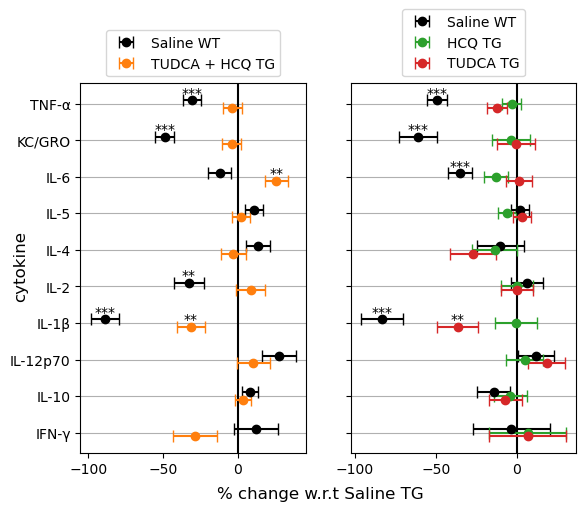

In [15]:
def my_errorbar_ax(ax, experiment='TUDCA or HCQ', estimatesd=estimatesd, sexes='both sexes'):
    dff = normalize_estimates(estimatesd[experiment]).xs(sexes, level=0, axis=1)
    l = list(dff.columns.to_frame()[0].drop('Intercept').drop('Treatment[T.Saline WT]').unique())
    l = ['Treatment[T.Saline WT]'] + l
    colord = {
        'TUDCA and HCQ': ['k', 'C1'],
        'TUDCA or HCQ': ['k', 'C2', 'C3'],
    }
    colorl = colord[experiment]
    Z = zip(l, np.linspace(0.1, -0.1, len(l)), colorl)
    ax.axvline(0, color='k')
    for param, offset, color in Z:
        df = dff[param]
        label = re.sub('^Treatment\\[T\\.(.*)\\]$', '\\1', param)
        yticks = np.arange(df.shape[0])
        ax.errorbar(y=yticks + offset, x=df['params'], xerr=df['bse'], fmt='o', capsize=4, label=label, color=color)
        pvalues = df['pvalues']
        for ytick in yticks:
            pass
            pvalue = pvalues.iloc[ytick]
            if pvalue < 1e-2:
                if pvalue < 5e-2:
                    s = '*'
                if pvalue < 1e-2:
                    s = '**'
                if pvalue < 1e-3:
                    s = '***'
                x = df['params'].iloc[ytick]
                y = ytick + offset
                ax.text(y=y, x=x, s=s, horizontalalignment='center', verticalalignment='bottom')
    ax.set_yticks(list(range(df.shape[0])))
    ax.set_yticklabels(dff.index)
    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0))
    return(ax)
    
def my_errorbar(experimentl=['TUDCA and HCQ', 'TUDCA or HCQ'], sexesl=['both sexes'] * 2, estimatesd=estimatesd):
    ncol = len(experimentl)
    fig, ax = plt.subplots(1, ncol, sharey=True)
    for axi, experiment, sexes in zip(ax, experimentl, sexesl):
        my_errorbar_ax(axi, experiment=experiment, estimatesd=estimatesd, sexes=sexes)
    fig.supxlabel('% change w.r.t Saline TG')
    fig.supylabel('cytokine')
    return((fig, ax))

fig, ax = my_errorbar(experimentl=['TUDCA and HCQ', 'TUDCA or HCQ'], sexesl=['both sexes'] * 2, estimatesd=estimatesd)
attila_utils.savefig(fig, 'estimates-TUDCA-and-orHCQ')

['named-figure/estimates-TUDCA-and-orHCQ-males-only.png',
 'named-figure/estimates-TUDCA-and-orHCQ-males-only.pdf']

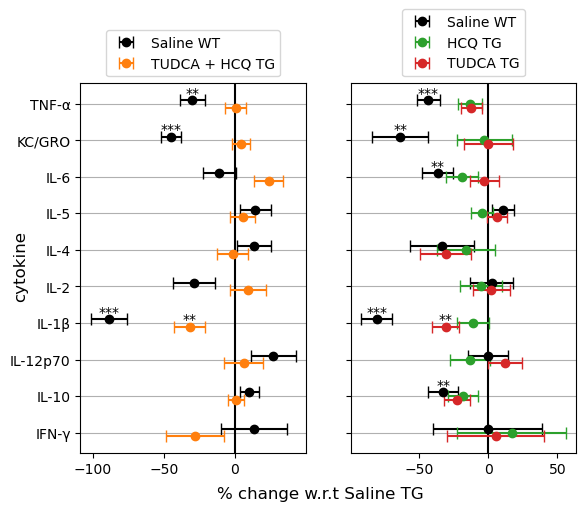

In [16]:
fig, ax = my_errorbar(experimentl=['TUDCA and HCQ', 'TUDCA or HCQ'], sexesl=['males only'] * 2, estimatesd=estimatesd)
attila_utils.savefig(fig, 'estimates-TUDCA-and-orHCQ-males-only')

In [17]:
%connect_info

{
  "shell_port": 56025,
  "iopub_port": 56026,
  "stdin_port": 56027,
  "control_port": 56029,
  "hb_port": 56028,
  "ip": "127.0.0.1",
  "key": "e2d6d6ed-c2921f9dba41796931de2ccd",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "conda-base-py",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-11-11-cytokines/Untitled.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-f10d4bc6-dc36-4afa-8bf7-78bedbee4226.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
